In [382]:
import pandas as pd
import numpy as np
import re
import seaborn
seaborn.set()
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline 
style.use('ggplot')
#style.use('fivethirtyeight')
import faker
from faker import Faker
from random import sample
from datetime import datetime, timedelta
from datetime import date
import datetime
import random
from random import randint

########Focusing on the Impact of Mail Campign##############

Generate Campign info table 

In [209]:
####Sample Size####
n = 1000
x = 0.5 # percentage to take for Mail Campign
m = 500
####Adjust the Price and Units to watch the different impact####
Mail_StartDate, Mail_EndaDate, Mail_price, Mail_Unit,Mail_Bor = '2018-02-01','2018-03-01', 10,m,'Manhattan'

#####Create Campign info table to record all the campagin details####
data = np.array([['Campign_Name','StartDate','EndDate','Price','Units','Borough'],
                ['TV','2018-01-01','2018-04-01', 5,n,'Manhattan'],
                ['Mail',Mail_StartDate, Mail_EndaDate, Mail_price, m, Mail_Bor],
                ['Radio','2018-03-01','2018-04-01', 12,300,'Manhattan']]) 

campign_info = pd.DataFrame(data = data[1:,:],
                            columns = data[0,:])
campign_info

,Campign_Name,StartDate,EndDate,Price,Units,Borough
0,TV,2018-01-01,2018-04-01,5,1000,Manhattan
1,Mail,2018-02-01,2018-03-01,10,500,Manhattan
2,Radio,2018-03-01,2018-04-01,12,300,Manhattan


Create Resident Info, when they are affected by campagin, GrubHub enrollment status and enrollment Start date

In [367]:
class Resident:
    def __init__(self): #, Enrollment, Enrollment_StartDatem, Mail_Target, Train_Target):
    self.fake = Faker()
    self.FirstName = self.fake.first_name()
    self.LastName = self.fake.last_name()
    self.Address = self.fake.street_name()
    self.PhoneNumber = self.fake.phone_number()
 
resident_info = pd.DataFrame(columns =['FirstName','LastName','Address','Borough','PhoneNumer','Enrollment',
                                       'Enrollment_StartDate','TV_Target','Mail_Target','Train_Target'])
for i in range(n):
        resident = Resident()
        resident_info.loc[i,:] = [resident.FirstName,resident.LastName,resident.Address,'Manhattan',resident.PhoneNumber,
                                   False, None, False, False, False]
        resident_info.loc[i,'TV_Target'] = True
rindex =  np.array(sample(range(len(resident_info)), m))
resident_info.loc[rindex,'Mail_Target'] = True


In [368]:
resident_info.head()

,FirstName,LastName,Address,Borough,PhoneNumer,Enrollment,Enrollment_StartDate,TV_Target,Mail_Target,Train_Target
0,Jenna,Dyer,Walker Shoal,Manhattan,1-862-548-8898,False,None,True,True,False
1,Christopher,Lewis,Smith Hill,Manhattan,713-200-8707x583,False,None,True,True,False
2,Scott,Lucas,David Fork,Manhattan,(153)403-2670,False,None,True,True,False
3,Jeffrey,Henderson,Beasley Streets,Manhattan,(470)976-2968x60444,False,None,True,True,False
4,Ronald,Wiggins,Johnson Mount,Manhattan,837-084-0003,False,None,True,True,False


####Simulate the TV Campign and Mail Campign####
Let's assume that the number customers coming from TV is having a linear relation with the # of days since the campign started(need a deeper analysis):
number of Customers(TV) = 2Days + 150 

In [369]:
datelist = pd.date_range('2018-01-01', '2018-03-01').tolist() # focusing the date TV and Mail Campign involved
cus_old = 0
Customer_status = []
for date_now in datelist:
    ###### Simulate the Customer Growth from TV Campagin
    days = str(date_now - datetime.datetime.strptime('2018-01-01 00:00:00', "%Y-%m-%d %H:%M:%S")) 
    TV_Customer  = 2 * int(days.split(" ")[0]) + 100
    TV_cus_new = TV_Customer - cus_old
    #group 1 where We have both TV Campign but not Mail Campign
    sample_list = []
    for i in resident_info[(resident_info['Enrollment'] == False) & (resident_info['TV_Target'] == True) 
                           & (resident_info['Mail_Target'] == False)].index:
        sample_list.append(i)
        
    for j in random.sample(sample_list,TV_cus_new):
        resident_info.loc[j,"Enrollment"] = True
        resident_info.loc[j,"Enrollment_StartDate"] = date_now
        
    #group 2 where We have both TV Campign and Mail Campign
    sample_list = []
    for i in resident_info[(resident_info['Enrollment'] == False) & (resident_info['TV_Target'] == True) 
                           & (resident_info['Mail_Target'] == True)].index:
        sample_list.append(i)
    for j in random.sample(sample_list,TV_cus_new):
        resident_info.loc[j,"Enrollment"] = True
        resident_info.loc[j,"Enrollment_StartDate"] = date_now
        
    ####Simulate the Customer Growth from Mail Campign
    if date_now >= datetime.datetime.strptime('2018-02-01 00:00:00', "%Y-%m-%d %H:%M:%S"):
        Mail_New_Customer = randint(0,5) 
        sample_list = []
        for i in resident_info[(resident_info['Enrollment'] == False) & (resident_info['TV_Target'] == True) 
                           & (resident_info['Mail_Target'] == True)].index:
            sample_list.append(i)
        for j in random.sample(sample_list,Mail_New_Customer):
            resident_info.loc[j,"Enrollment"] = True
            resident_info.loc[j,"Enrollment_StartDate"] = date_now
    
    #print(len(sample_list))
    cus_old = TV_Customer
resident_info.head()

,FirstName,LastName,Address,Borough,PhoneNumer,Enrollment,Enrollment_StartDate,TV_Target,Mail_Target,Train_Target
0,Jenna,Dyer,Walker Shoal,Manhattan,1-862-548-8898,True,2018-01-01 00:00:00,True,True,False
1,Christopher,Lewis,Smith Hill,Manhattan,713-200-8707x583,True,2018-02-13 00:00:00,True,True,False
2,Scott,Lucas,David Fork,Manhattan,(153)403-2670,True,2018-01-01 00:00:00,True,True,False
3,Jeffrey,Henderson,Beasley Streets,Manhattan,(470)976-2968x60444,True,2018-01-28 00:00:00,True,True,False
4,Ronald,Wiggins,Johnson Mount,Manhattan,837-084-0003,False,None,True,True,False


Calculate the three types of Differences 

In [370]:
D1 =len(resident_info[(resident_info['Enrollment'] == True) & (resident_info['TV_Target'] == True) 
                           & (resident_info['Mail_Target'] == True)].index)
D2 =len(resident_info[(resident_info['Enrollment'] == True) & (resident_info['TV_Target'] == True) 
                           & (resident_info['Mail_Target'] == False)].index)
print(D1,D2)
D3 = D1 - D2
print("D1 - D2 = " + str(D3))

351 218
D1 - D2 = 133


Visulize the Customer Growth for two Groups

In [463]:
Group1 = resident_info['Enrollment_StartDate'][(resident_info['Enrollment'] == True) & (resident_info['TV_Target'] == True) 
                           & (resident_info['Mail_Target'] == False)].groupby(resident_info['Enrollment_StartDate']
                                                                             ).count()
group_dic = {}
for i in Group1.index:
    if group_dic =={}:
        group_dic[i] = int(Group1[i])
    else:
        group_dic[i] = int(Group1[i]) + group_dic[i-timedelta(days=1)]

Gourp1_keyList = group_dic.keys()
Gourp1_ValueList = group_dic.values()

Group2 = resident_info['Enrollment_StartDate'][(resident_info['Enrollment'] == True) & (resident_info['TV_Target'] == True) 
                                               & (resident_info['Mail_Target'] == True)].groupby(resident_info['Enrollment_StartDate']
                                                                                                ).count()
group_dic = {}
standard1 = {}
standard2 = {}
for i in Group2.index:
    standard1[i] = int(Group2[0])
    if group_dic =={}:
        group_dic[i] = int(Group2[i])
        standard[i] = int(Group2[i])
    else:
        group_dic[i] = int(Group2[i]) + group_dic[i-timedelta(days=1)]
    if i == datetime.datetime.strptime('2018-01-31 00:00:00', "%Y-%m-%d %H:%M:%S"):
        standard2[i] = group_dic[i]
    elif i > datetime.datetime.strptime('2018-01-31 00:00:00', "%Y-%m-%d %H:%M:%S"):
        standard2[i] = int(standard2[i-timedelta(days=1)])

Gourp2_keyList = group_dic.keys()
Gourp2_ValueList = group_dic.values()

Standard1_keyList = standard1.keys()
Standard1_ValueList = standard1.values()

Standard2_keyList = standard2.keys()
Standard2_ValueList = standard2.values()

D1 = 351 ; D2 = 218 
D3 = D1 - D2 = 133 (No. New Customers from Mail Campign)


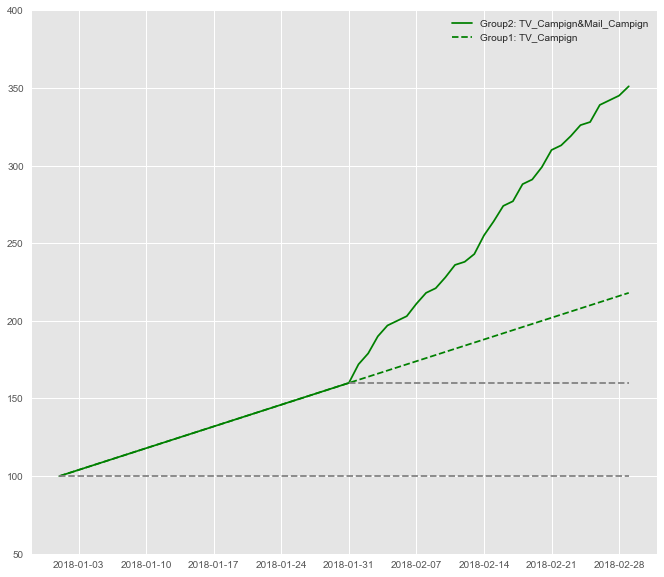

In [486]:
print("D1 = " + str(D1),"; D2 = "+str(D2), "\nD3 = D1 - D2 = " + str(D1 - D2) + " (No. New Customers from Mail Campign)")
plt.plot(Gourp2_keyList, Gourp2_ValueList, 'G', label='Group2: TV_Campign&Mail_Campign')
plt.plot(Gourp1_keyList, Gourp1_ValueList, 'g--', label='Group1: TV_Campign')
plt.plot(Standard1_keyList, Standard1_ValueList, color='gray', linestyle='dashed')
plt.plot(Standard2_keyList, Standard2_ValueList, color='gray', linestyle='dashed')
plt.legend()
plt.ylim((50,400))
plt.figure(figsize=(5,10))
plt.show()